In [1]:
import torch

# Loading the data and checking the availability of GPU

First, we need to check if GPU is available. Utilizing GPU acceleration is a great way to speed up the training process

In [2]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
print(device)

cuda:0


## Loading the data 

For our deep learning project, we choose the rice dataset from Kaggle.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!unzip "/content/drive/MyDrive/Colab_Notebooks/DL_PROJECT/rice_dataset.zip" -d "/content/drive/MyDrive/Colab_Notebooks/DL_PROJECT"

### importing the libraries : pathlib for directories and os for operating system

In [5]:
import pathlib

In [6]:
import os

We can check the number of images for each class in our dataset: in our case, there are 5 classes which represent 5 types of rice: Arborio, Basmati, Jasmine, Ipsala and Karacadag

In [7]:
data_dir = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

path = pathlib.Path(data_dir)

arborio = list(path.glob('Arborio/*'))
print("the length of arborio; %d" % len(arborio))

Basmati = list(path.glob('Basmati/*'))
print("the length of Basmati: %d" % len(Basmati))

Jasmine = list(path.glob('Jasmine/*'))
print("the length of Jasmine: %d" % len(Jasmine))

Karacadag = list(path.glob('Karacadag/*'))
print("the length of Karacadag: %d" % len(Karacadag))

Ipsala = list(path.glob('Ipsala/*'))
print("the length of Ipsala: %d" % len(Ipsala))

# Each image file has 15 000 images 

the length of arborio; 15000
the length of Basmati: 15000
the length of Jasmine: 15000
the length of Karacadag: 15000
the length of Ipsala: 15000


In [8]:
cont = os.listdir(data_dir)

print(cont) # we can see here the classes


['Karacadag', 'Basmati', 'Jasmine', 'Rice_Citation_Request.txt', 'Arborio', 'Ipsala']


# Pre-processing

Firs of all, we import the libraries we will be using.

In [9]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os

# for the preprocessing part
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms

We will use the transforms.Compose function for resizing and normalizing the data.

In [10]:

transformer = torchvision.transforms.Compose(
    [  
        torchvision.transforms.Resize((128, 128)), #The image size will be 128x128 pixels.
        torchvision.transforms.ToTensor(), #Converting the images into PyTorch tensors.
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] #Normalizing the images, the choice of the mean and std is derived from the statistics of the RGB channels
        ),
    ]
)

# ImageFolder allows us to create a dataset that automatically arranges images into classes based on the folder name
rice_dat = torchvision.datasets.ImageFolder(data_dir, transform=transformer)

Here we can observe the label of each type of rice. This process was done using ImageFolder.

In [11]:
class_labels = rice_dat.class_to_idx
print(class_labels)

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [12]:
len(rice_dat) # We have 75 000 images in our dataset

75000

the images are of size 128x128 pixels and 3 channels (RGB)

In [13]:
img, label = rice_dat[0]
print(img.shape,label) # the size of the image is 128x128 with 3 channels (RGB)

torch.Size([3, 128, 128]) 0


### Displaying an image from the dataset with its corresponding label.

In [14]:
import matplotlib.pyplot as plt

label : Arborio


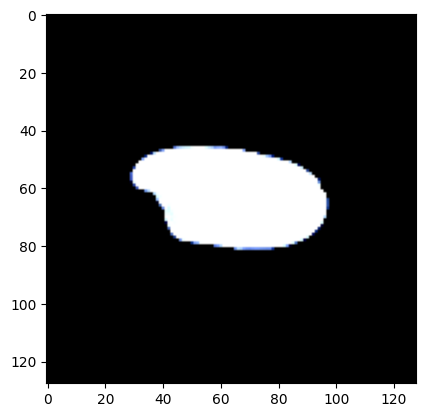

In [15]:
#displaying the data

def display_image(img,label):
  print(f"label : {rice_dat.classes[label]}")
  plt.imshow(img.permute(1,2,0))

#DISPLAY
display_image(*rice_dat[0]) # the Arborio image in this case

### spliting the dataset 

* We will split the dataset into 3 sets: train, test and validation.
* We will take 70% from the dataset for training, 15% for testing and 15% for validation.


In [16]:
# Define the sizes for training and test sets
train_size = int(0.7 * len(rice_dat))  # %70for training
test_size = int(0.15 * len(rice_dat))  # %15 for testing
valid_size = int(len(rice_dat)) - train_size - test_size #15% for validation

printing the sizes of each set.

In [17]:

print(train_size)
print(test_size)
print(valid_size)

52500
11250
11250


Then, we use the random_split function to split the dataset. this function randomly shuffles and assigns the data point to each subset on a proportional basis.
* We will result in 3 sets: train_dataset, test_dataset and valid_dataset

In [18]:
# Use random_split to create training , validation and testing  sets
train_dataset, test_dataset, valid_dataset = random_split(rice_dat, [train_size, test_size, valid_size])

## Creating the data loaders

In this section, we create 3 data loaders corresponding to each dataset to proficiently load and batch each set during the training process.

* The batch size will be 64 number of samples in each mini-batch
* The shuffle argument prevent the model to remember the order of the data. True for the train and validation sets, and False for test set.

In [31]:
# Create DataLoader for training and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=4)

In [32]:
dataloaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}


# CONVOLUTIONAL NEURAL NETWORK MODEL 

We will create a CNN model with 3 convolutional layers and 2 fully connected layers. 

In [21]:
import torch.nn as nn


In this section, we will define an architecture for the CNN model that we will use for the image classification task.

Our custom CNN model class named ConvNeuralNet inherits from nn.Module from Pytorch. Each convolutional layer has a max Pooling layer and an activation function.

In [22]:


class ConvNeuralNet(nn.Module):
  #the  layers of the network and their oder in CNN object
  def __init__(self, num_classes):
    super(ConvNeuralNet, self).__init__()
    # 3 convolutinal layers 
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size= 4, padding= 1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size= 4, padding= 1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size= 4, padding= 1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # 2 fully connected layers
    self.fc4= nn.Linear(32*15*15, 512)
    self.relu4= nn.ReLU()

    self.fc5= nn.Linear(512, num_classes)


  def forward(self, x):
    

    out=self.conv1(x)
    out=self.relu1(out)
    out=self.pool1(out)

    out=self.conv2(out)
    out=self.relu2(out)
    out=self.pool2(out)

    out=self.conv3(out)
    out=self.relu3(out)
    out=self.pool3(out)
    

    
    
    out = out.view(-1, 32*15*15)
    out= self.fc4(out)
    out = self.relu4(out)

    out = self.fc5(out)
    return out

# the number of classes is determined bases on the dataset
num_classes = len(rice_dat.classes)
model = ConvNeuralNet(num_classes)








In [48]:
model = model.to(device) #moving the model to the device 
model #displaying the model


ConvNeuralNet(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=7200, out_features=512, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=512, out_features=5, bias=True)
)

In [26]:
num_classes # 5 classes representing the 5 types of rice

5

In [27]:
# Verify device assignment
print("Model device:", next(model.parameters()).device)


Model device: cuda:0


In [ ]:
model = model.to(device)
print("Model device:", next(model.parameters()).device)


## Defining the Loss function and Optimizer

We will set up the necessary components for training the CNN model. 
* The Loss function : we choose the Cross Entropy Loss
* The Optimizer :  we choose the Adam Optimizer

In [28]:
import torch.optim as optim

In [29]:
Loss = nn.CrossEntropyLoss()
Optimizer = optim.Adam(model.parameters(), lr= 0.0001)

## TRAINING and VALIDATING THE MODEL

We will implement the training and the validation loop to train the CNN model on the rice image dataset. This loop will run for 10 epochs.

In [33]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    #loading the data in batches
    for i, (images,labels) in enumerate(train_loader):
        #moving the tensor to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        #forward propagation
        outputs = model(images) #final prediction
        loss = Loss(outputs, labels)
        #backward propagation and optimization
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        # append the loss
        run_loss = 0.0
        run_loss += loss.item()
        
    train_loss = run_loss / len(train_loader)
    train_losses.append(train_loss)
    
    with torch.no_grad() :
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        all_val_loss = []
        for images, labels in valid_loader : 
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            total += labels.size(0)
            #calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            #calculate actual values
            correct += (predicted == labels).sum().item()
            
            loss = Loss(outputs, labels)
            val_loss += loss.item()
            #calculate the loss
            all_val_loss.append(val_loss)
            #calculate validation loss
            mean_val_loss = (sum(all_val_loss) / len(all_val_loss))
            
            #calculate validation accuracy
            mean_val_accuracy = 100 * (correct / total)
        
        val_accuracy = correct / len(valid_loader)
        val_losses.append(val_loss / len(valid_loader))
        val_accuracies.append(val_accuracy)
    print (
      'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
          epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_accuracy
      )
    )
    





Epoch [1/10], Loss: 0.0416, Val-loss: 4.3590, Val-acc: 98.5%
Epoch [2/10], Loss: 0.0350, Val-loss: 2.7590, Val-acc: 98.8%
Epoch [3/10], Loss: 0.0019, Val-loss: 3.3454, Val-acc: 98.8%
Epoch [4/10], Loss: 0.1082, Val-loss: 2.2181, Val-acc: 99.1%
Epoch [5/10], Loss: 0.0063, Val-loss: 2.2320, Val-acc: 99.2%
Epoch [6/10], Loss: 0.0840, Val-loss: 2.3373, Val-acc: 99.0%
Epoch [7/10], Loss: 0.0183, Val-loss: 1.9342, Val-acc: 99.2%
Epoch [8/10], Loss: 0.0036, Val-loss: 2.2415, Val-acc: 99.1%
Epoch [9/10], Loss: 0.0045, Val-loss: 2.0526, Val-acc: 99.3%
Epoch [10/10], Loss: 0.0330, Val-loss: 2.0563, Val-acc: 99.2%


**The 10th epoch gave us 99.2% accuracy, which is very good.

#### SAVING THE TRAINED MODEL 

In [34]:
torch.save(model, 'CNN_model')
# load from file and switch to inference mode
model = torch.load('CNN_model')
model.eval()


ConvNeuralNet(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=7200, out_features=512, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=512, out_features=5, bias=True)
)

# Visualizing the graphs 

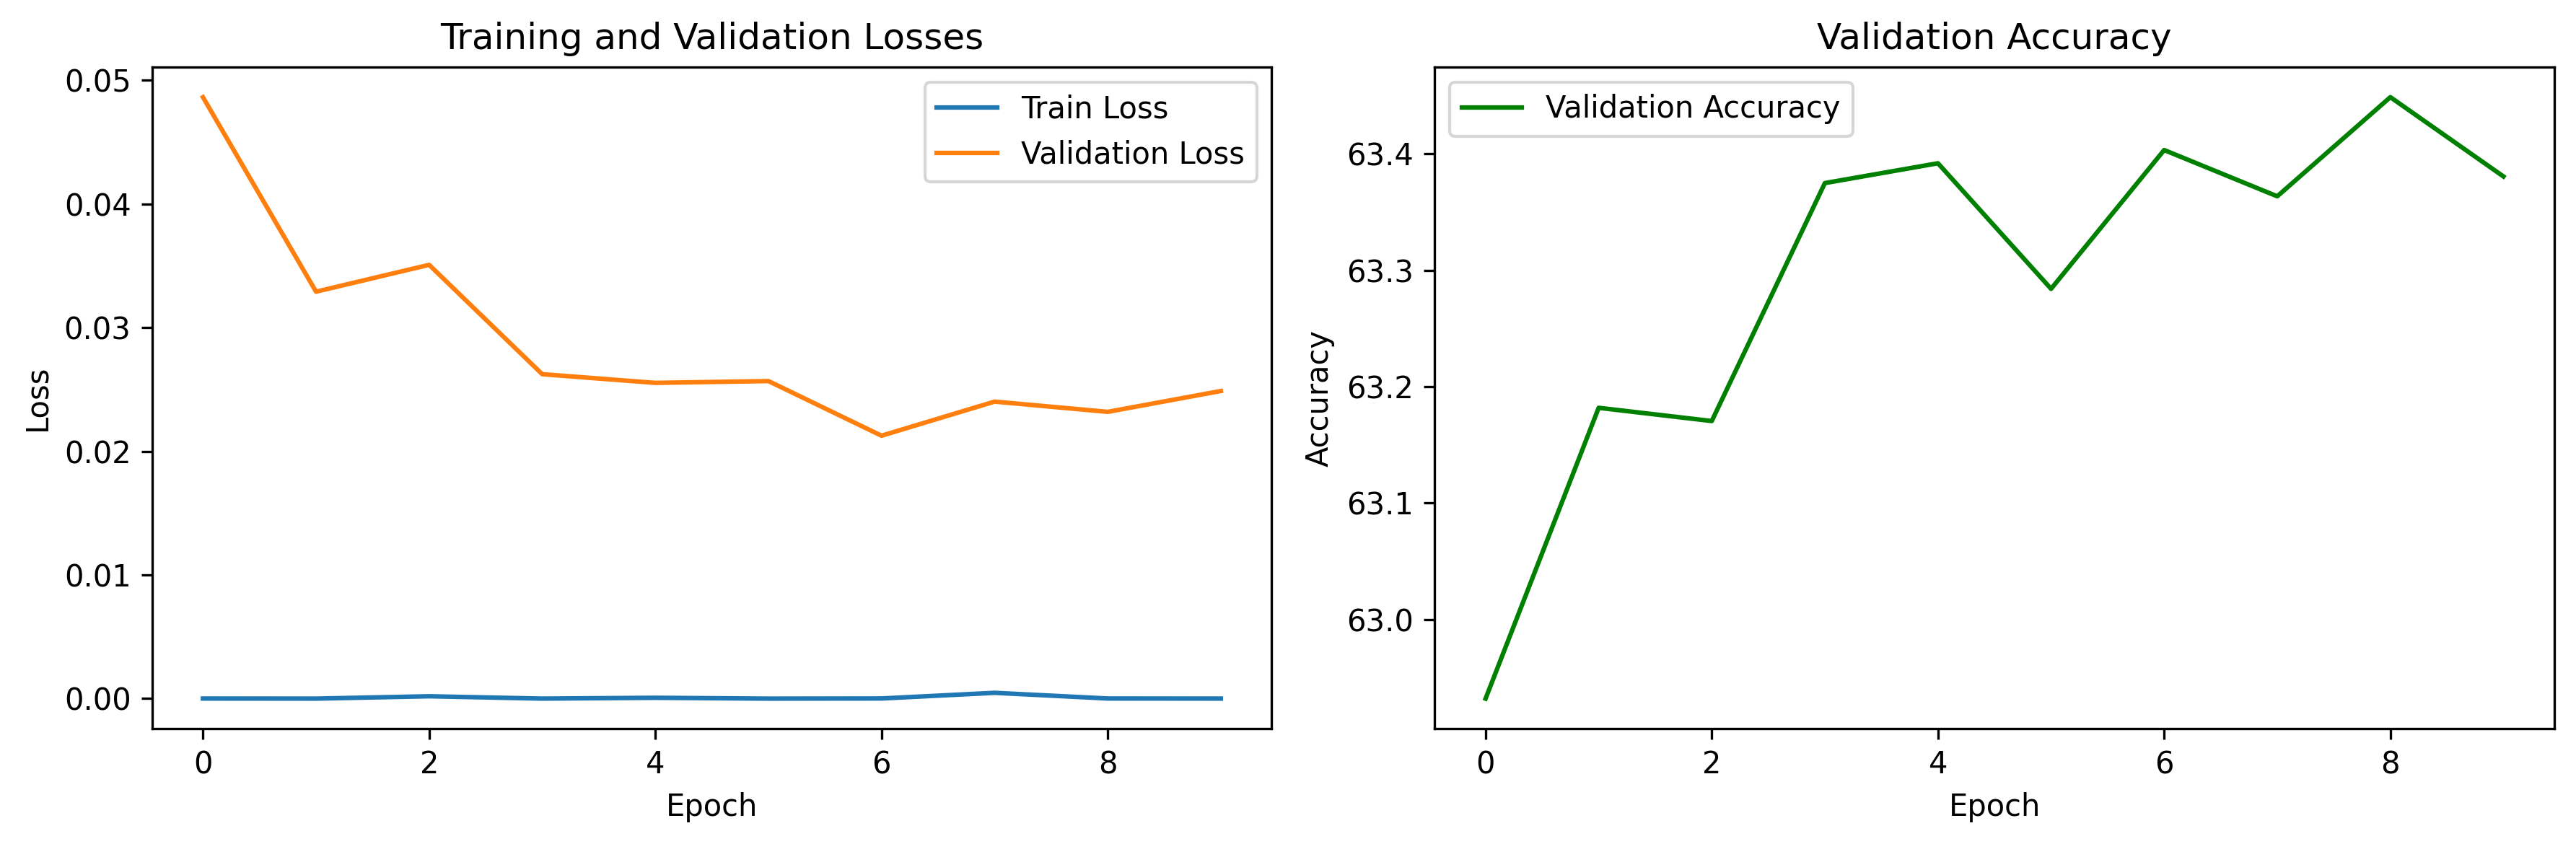

In [35]:
# Plotting
plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = model.to(device)
print("Model device:", next(model.parameters()).device)


### EVALUATING THE MODEL PERFORMANCE ON THE SET DATASET

We will evaluate the trained model's performance on the test dataset, wich allows us to measure its accuracy on a n unseen data.

In [36]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test dataset: {100 * correct // total} %')

Accuracy of the network on the test dataset: 99 %


## VISUALIZING THE METRICS AND PREDICTIONS

In [37]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [41]:
model.eval()
y_pred = []
y_labels = []
model = model.cpu()
# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_labels.extend(labels) # Save labels


In [42]:
classes_names = rice_dat.classes

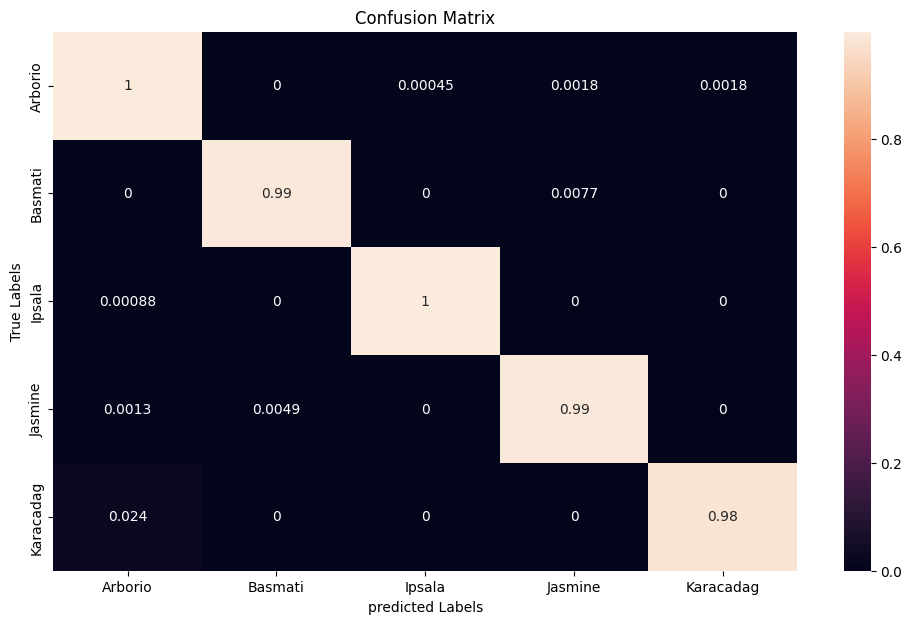

In [44]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_labels, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes_names],
                     columns = [i for i in classes_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# visualizing the images and their predictions 

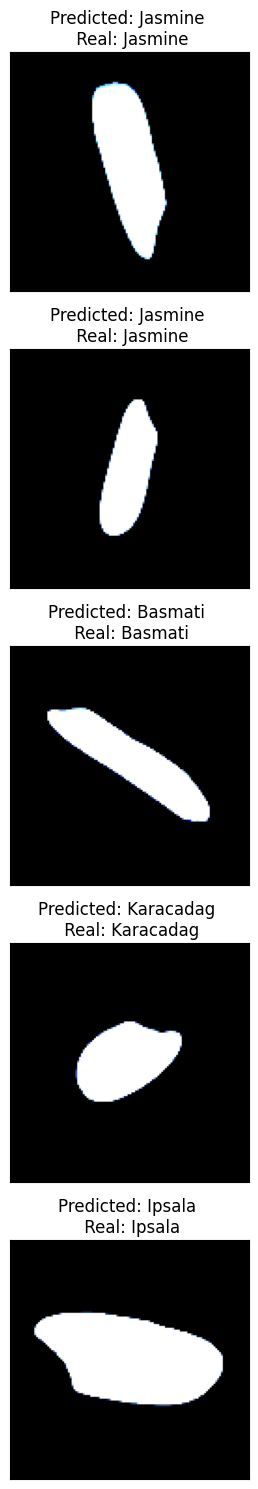

In [50]:
model = model.cpu()
with torch.no_grad():
    count = 0
    plt.figure(figsize=(5, 15))
    for img, label in test_loader:
        for i in range(len(img)):
            imgs = img[i]
            labels = label[i]
            output_model = imgs.unsqueeze(0)
            output_model = model(output_model)
            index = output_model.argmax()
            imgs = torch.permute(imgs, (1, 2, 0))
            plt.subplot(5, 1, count + 1)
            plt.imshow(imgs)
            plt.title(f"Predicted: {rice_dat.classes[index]} \n Real: {rice_dat.classes[labels]}", fontsize=12)
            plt.xticks([])  
            plt.yticks([])  
            count += 1
            if count >= 5:
                break
        if count >= 5:
            break
    plt.tight_layout()  
    plt.show()
